In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from torch.utils.data import ConcatDataset, DataLoader
import torch.optim as optim
import pandas as pd



## 1. Data Preprocessing

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

train_size = int(0.83 * len(full_train_data))   # ~50,000
val_size = len(full_train_data) - train_size    # ~10,000
train_data, val_data = random_split(full_train_data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)

test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [4]:
train_data.__getitem__(0)[0].shape

torch.Size([1, 28, 28])

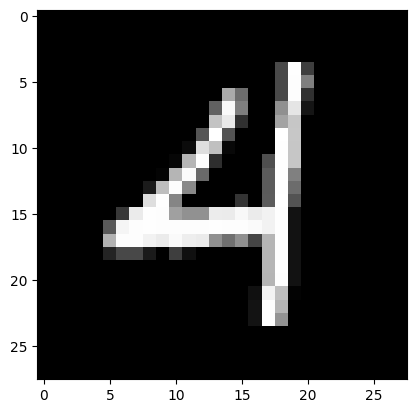

In [5]:
plt.imshow(train_data.__getitem__(0)[0].squeeze(), cmap='gray') 

## 2. Model

In [2]:


class FeedforwardNN(nn.Module):
    def __init__(self, layer_sizes, activation='relu'):
    
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
        
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'leaky_relu':
            self.activation = F.leaky_relu
        else:
            raise ValueError("Unsupported activation")

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)  
        return x


model = FeedforwardNN([784, 128, 64, 10], activation='relu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


## 3. Training

In [3]:
def train_one_run(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
    return train_losses, val_losses, train_accuracies, val_accuracies


In [9]:
num_runs = 5
num_epochs = 10

all_train_losses = []
all_val_losses = []
all_train_acc = []
all_val_acc = []

for run in range(num_runs):
    print(f"=== Run {run+1}/{num_runs} ===")
    model = FeedforwardNN([784, 256, 128, 64, 10], activation='relu')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    
    train_losses, val_losses, train_acc, val_acc = train_one_run(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)


=== Run 1/5 ===
=== Run 2/5 ===
=== Run 3/5 ===
=== Run 4/5 ===
=== Run 5/5 ===


### Test eval

In [10]:
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader.dataset)
test_acc = 100 * correct / total

print(f"\n✅ Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


✅ Final Test Loss: 0.0918, Test Accuracy: 97.29%


In [11]:
import numpy as np

mean_train_loss = np.mean(all_train_losses, axis=0)
std_train_loss = np.std(all_train_losses, axis=0)

mean_val_loss = np.mean(all_val_losses, axis=0)
std_val_loss = np.std(all_val_losses, axis=0)

mean_train_acc = np.mean(all_train_acc, axis=0)
std_train_acc = np.std(all_train_acc, axis=0)

mean_val_acc = np.mean(all_val_acc, axis=0)
std_val_acc = np.std(all_val_acc, axis=0)


In [12]:
mean_train_loss.shape
# get the mean of epoch 1 from run 1,2,3,4 and 5 and so on for other epochs

(10,)

## 4. Performance Visualization

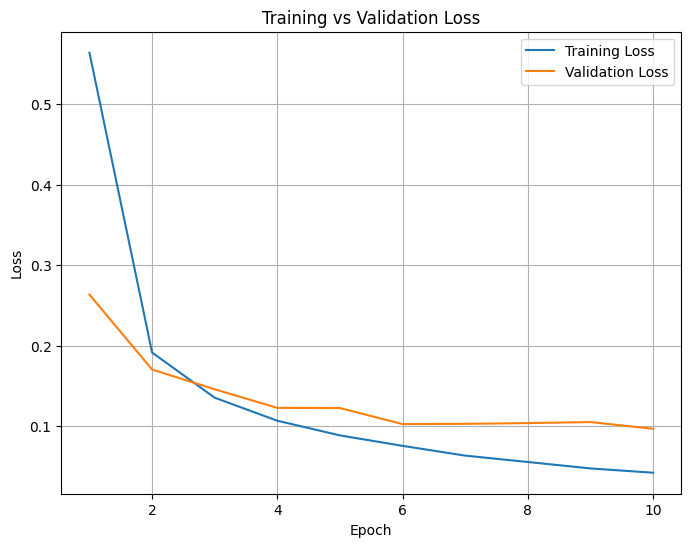

In [13]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(8,6))
plt.plot(epochs_range, mean_train_loss, label='Training Loss')
plt.plot(epochs_range, mean_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


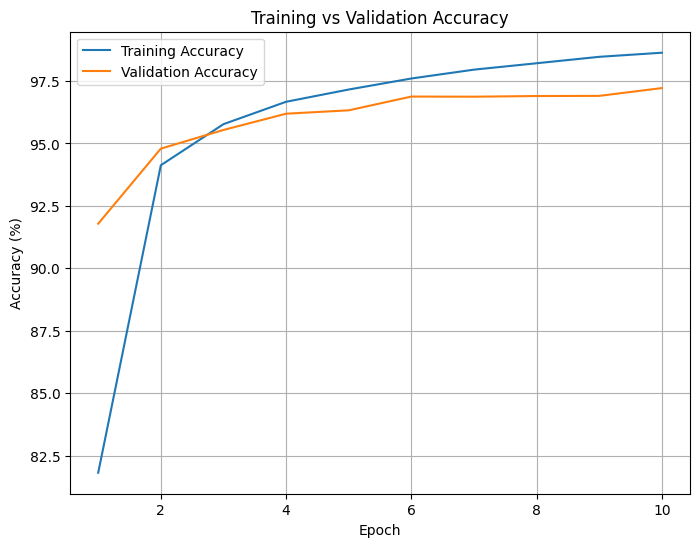

In [14]:
plt.figure(figsize=(8,6))
plt.plot(epochs_range, mean_train_acc, label='Training Accuracy')
plt.plot(epochs_range, mean_val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


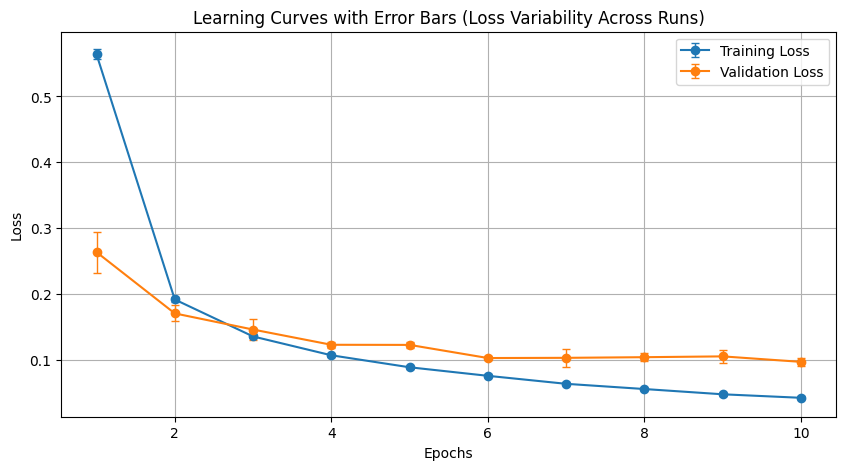

In [15]:
plt.figure(figsize=(10,5))
plt.errorbar(epochs_range, mean_train_loss, yerr=std_train_loss, fmt='-o', 
             label='Training Loss', capsize=3, elinewidth=1, capthick=1)
plt.errorbar(epochs_range, mean_val_loss, yerr=std_val_loss, fmt='-o', 
             label='Validation Loss', capsize=3, elinewidth=1, capthick=1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves with Error Bars (Loss Variability Across Runs)')
plt.legend()
plt.grid(True)
plt.show()


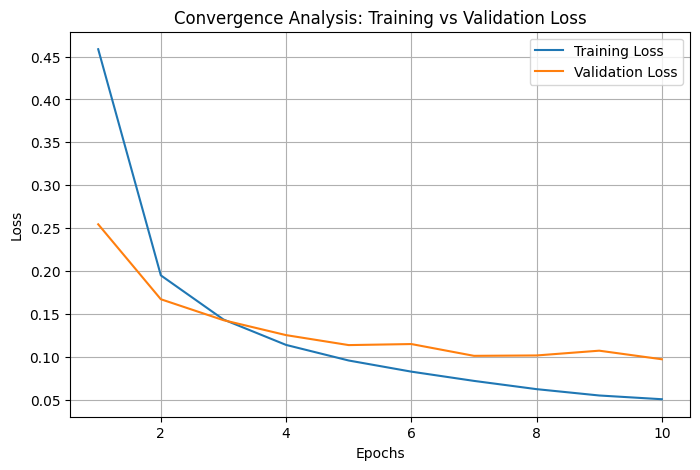

In [57]:
plt.figure(figsize=(8,5))
plt.plot(epochs_range, mean_train_loss, label='Training Loss')
plt.plot(epochs_range, mean_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Convergence Analysis: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


### Observation:

Training loss decreases smoothly from ~0.45 to ~0.05.

Validation loss follows closely, dropping from ~0.25 to ~0.10.

Both curves flatten around epoch 7–8, indicating that the model stopped making significant improvements.

No sign of divergence (validation loss doesn’t increase).

Conclusion:
    The model successfully converged — both training and validation losses reached stable values.

## 5. Hyperparameter Analysis

### Learning rates


=== Training with Learning Rate = 0.001 ===

=== Training with Learning Rate = 0.01 ===

=== Training with Learning Rate = 0.1 ===

=== Training with Learning Rate = 1.0 ===


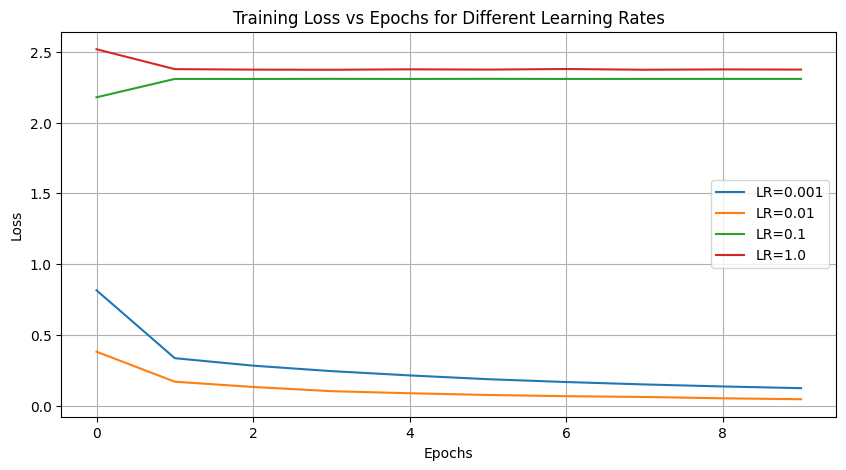

In [18]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
num_epochs = 10

results_lr = {}

for lr in learning_rates:
    print(f"\n=== Training with Learning Rate = {lr} ===")
    model = FeedforwardNN([784, 128, 64, 10], activation='relu')
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_acc, val_acc = train_one_run(model, train_loader, val_loader, criterion, optimizer, num_epochs)
    results_lr[lr] = (train_losses, val_losses, train_acc, val_acc)

# Plot training loss for all LRs
plt.figure(figsize=(10,5))
for lr, (train_losses, _, _, _) in results_lr.items():
    plt.plot(train_losses, label=f'LR={lr}')
plt.title("Training Loss vs Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Gradient noise code

In [7]:

def estimate_gradient_noise(model, loader, criterion, num_batches=10):
    grads = []
    data_iter = iter(loader)

    for i in range(num_batches):
        x, y = next(data_iter)
        x, y = x.to(next(model.parameters()).device), y.to(next(model.parameters()).device)

        model.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()

        # Flatten all gradients into a single vector
        grad_vector = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])
        grads.append(grad_vector.detach().cpu())

    grads = torch.stack(grads)
    grad_var = grads.var(dim=0).mean().item()
    return grad_var


### Batch sizes

In [11]:
import time

batch_sizes = [16, 32, 64, 128]
num_epochs = 10
results_bs = {}

for bs in batch_sizes:
    print(f"\n=== Training with Batch Size = {bs} ===")

    # Create loaders
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=False)

    model = FeedforwardNN([784, 128, 64, 10], activation='relu')
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    start = time.time()
    train_losses, val_losses, train_acc, val_acc = train_one_run(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )
    end = time.time()

    elapsed = end - start
    final_acc = val_acc[-1]

    grad_noise = estimate_gradient_noise(model, train_loader, criterion)
    print(f"Gradient Noise (variance estimate) for batch {bs}: {grad_noise:.6f}")

    results_bs[bs] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "time": elapsed,
        "final_acc": final_acc,
        "grad_noise": grad_noise
    }

    print(f"Time: {elapsed:.2f}s | Final Val Acc: {final_acc:.2f}% | efficiency: {final_acc/elapsed:.4f} %/s")

# Summarize results
rows = []
for bs, result in results_bs.items():
    rows.append([bs, result["time"], result["final_acc"], result["grad_noise"]])

df_bs = pd.DataFrame(rows, columns=["Batch Size", "Training Time (s)", "Final Val Accuracy (%)", "Gradient Noise"])
print(df_bs)



=== Training with Batch Size = 16 ===
Gradient Noise (variance estimate) for batch 16: 0.000027
Time: 160.87s | Final Val Acc: 96.60% | efficiency: 0.6005 %/s

=== Training with Batch Size = 32 ===
Gradient Noise (variance estimate) for batch 32: 0.000007
Time: 138.25s | Final Val Acc: 97.25% | efficiency: 0.7035 %/s

=== Training with Batch Size = 64 ===
Gradient Noise (variance estimate) for batch 64: 0.000017
Time: 121.09s | Final Val Acc: 96.70% | efficiency: 0.7985 %/s

=== Training with Batch Size = 128 ===
Gradient Noise (variance estimate) for batch 128: 0.000007
Time: 118.78s | Final Val Acc: 97.04% | efficiency: 0.8170 %/s
   Batch Size  Training Time (s)  Final Val Accuracy (%)  Gradient Noise
0          16         160.872715               96.598039        0.000027
1          32         138.253857               97.254902        0.000007
2          64         121.094825               96.696078        0.000017
3         128         118.777030               97.039216        0.

### Architecture Analysis

In [20]:
architectures = [
    [128, 64],                   # 2 hidden layers
    [256, 128, 64],              # 3 hidden
    [512, 256, 128, 64],         # 4 hidden
    [512, 256, 128, 64, 32]      # 5 hidden
]

results_arch = []

for arch in architectures:
    print(f"\n=== Training with Architecture: {arch} ===")
    
    layer_sizes = [784] + arch + [10]

    # Instantiate flexible model
    model = FeedforwardNN(layer_sizes, activation='relu')

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, train_acc, val_acc = train_one_run(
        model, train_loader, val_loader, criterion, optimizer, num_epochs
    )
    
    final_acc = val_acc[-1]
    results_arch.append((len(arch), arch, final_acc))

# Create comparison table
import pandas as pd
df_arch = pd.DataFrame(results_arch, columns=["# Hidden Layers", "Neurons per Layer", "Final Validation Accuracy"])
print(df_arch)


=== Training with Architecture: [128, 64] ===

=== Training with Architecture: [256, 128, 64] ===

=== Training with Architecture: [512, 256, 128, 64] ===

=== Training with Architecture: [512, 256, 128, 64, 32] ===
   # Hidden Layers        Neurons per Layer  Final Validation Accuracy
0                2                [128, 64]                  97.058824
1                3           [256, 128, 64]                  97.049020
2                4      [512, 256, 128, 64]                  97.294118
3                5  [512, 256, 128, 64, 32]                  97.294118


In [ ]:
'''
we can use Randomized Search for architecture analysis as:
import random

def random_architecture(num_layers_range=(2,5), neurons=[64,128,256,512]):
    n_layers = random.randint(*num_layers_range)
    return [random.choice(neurons) for _ in range(n_layers)]

architectures = [random_architecture() for _ in range(10)]

but it will take more time to run. like 1,360 different architectures.
'''

## Best Model Evaluation

Epoch [1/10] | Loss: 0.4689 | Acc: 84.19%
Epoch [2/10] | Loss: 0.1588 | Acc: 95.15%
Epoch [3/10] | Loss: 0.1188 | Acc: 96.39%
Epoch [4/10] | Loss: 0.0934 | Acc: 97.11%
Epoch [5/10] | Loss: 0.0749 | Acc: 97.58%
Epoch [6/10] | Loss: 0.0656 | Acc: 97.95%
Epoch [7/10] | Loss: 0.0557 | Acc: 98.25%
Epoch [8/10] | Loss: 0.0490 | Acc: 98.48%
Epoch [9/10] | Loss: 0.0415 | Acc: 98.66%
Epoch [10/10] | Loss: 0.0363 | Acc: 98.78%

⏱️ Total Training Time: 198.97s

✅ Weights saved to best_model_weights_flexible.pth

🎯 Final Test Accuracy: 97.80% | Test Loss: 0.0758

📁 Results saved to final_results.json


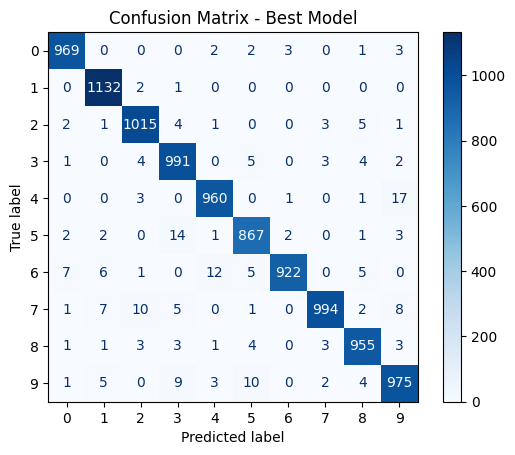

Total misclassified samples: 220


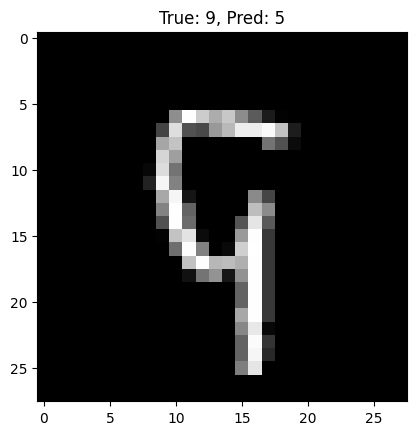

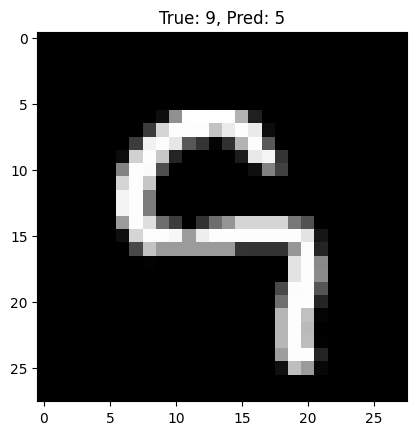

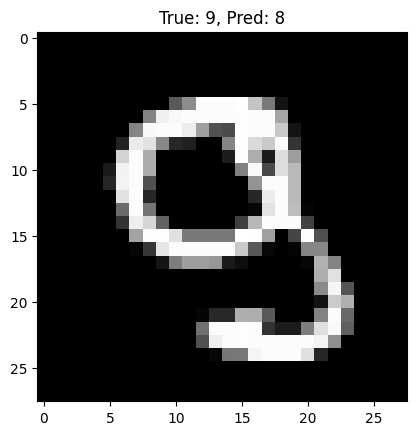

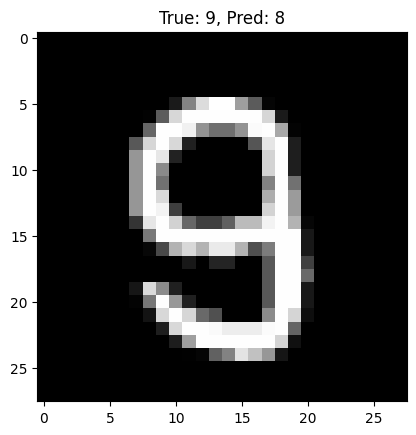

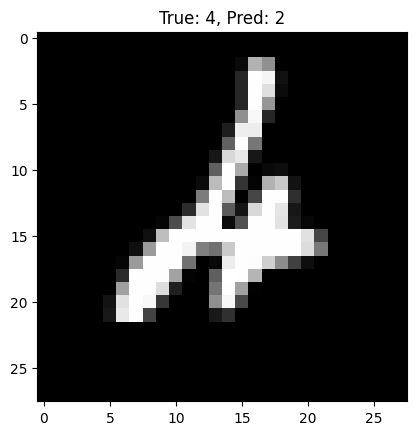

In [6]:
import time, json

best_lr = 0.01
best_batch_size = 32
best_arch = [512, 256, 128, 64]

# ======  Best Model Architecture ======
model = FeedforwardNN([784] + best_arch + [10], activation='relu')

# ====== 2. Prepare Combined Train + Validation Data ======
combined_dataset = ConcatDataset([train_data, val_data])
combined_loader = DataLoader(combined_dataset, batch_size=best_batch_size, shuffle=True)

# ====== 3. Train Final Model ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)

epochs = 10
start_time = time.time()  

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in combined_loader:
        images = images.view(images.size(0), -1)  # flatten 28x28 -> 784

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(combined_loader):.4f} | "
          f"Acc: {100*correct/total:.2f}%")

training_time = time.time() - start_time  
print(f"\n⏱️ Total Training Time: {training_time:.2f}s")

# ====== 4. Save Weights ======
torch.save(model.state_dict(), "best_model_weights_flexible.pth")
print("\n✅ Weights saved to best_model_weights_flexible.pth")

# ====== 5. Evaluate on Test Set ======
model.eval()
y_true, y_pred, test_losses = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)
test_loss = np.mean(test_losses)
test_acc = np.mean(y_true == y_pred)
print(f"\n🎯 Final Test Accuracy: {test_acc*100:.2f}% | Test Loss: {test_loss:.4f}")

# ====== 6. Save Results to JSON ======
results = {
    "best_lr": best_lr,
    "best_batch_size": best_batch_size,
    "best_architecture": best_arch,
    "epochs": epochs,
    "training_time_sec": round(training_time, 2),
    "test_accuracy_percent": round(test_acc * 100, 2),
    "test_loss": round(test_loss, 4)
}

with open("final_results.json", "w") as f:
    json.dump(results, f, indent=4)

print("\n📁 Results saved to final_results.json")

# ====== 7. Confusion Matrix ======
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix - Best Model")
plt.show()

# ====== 8. Misclassified Samples ======
mis_idx = np.where(y_true != y_pred)[0]
print(f"Total misclassified samples: {len(mis_idx)}")

for i in mis_idx[:5]:
    img, true_label = test_data[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {true_label}, Pred: {y_pred[i]}")
    plt.show()


In [66]:
# === Model Limitations ===
# 1. The model is fully connected (no convolutional layers), so it lacks spatial awareness.
#    It treats pixels independently and may perform poorly on shifted or rotated digits.
#
# 2. No regularization (e.g., dropout or weight decay) was applied.
#    This could lead to mild overfitting, especially with noisy or complex data.
#
# 3. The model only works on 28x28 grayscale inputs and cannot generalize to color or larger images.
#
# 4. No data augmentation was used, so it might struggle with variations in handwriting style or orientation.
#
# 5. Fully connected layers scale poorly with image size — parameter count grows rapidly.
#
# 6. The model behaves as a black box; it’s hard to interpret which features influenced its predictions.
#
# Overall, the model performs very well on MNIST (~97.5% test accuracy)
# but would not generalize effectively to more complex or real-world image data.
